In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')

df = pd.read_csv('./data/allcars.csv', index_col=0).reset_index(drop=True)

/home/cjporteo/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/cjporteo/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [2]:
df.head()

,timeStamp,tripID,accData,gps_speed,battery,cTemp,dtc,eLoad,iat,imap,kpl,maf,rpm,speed,tAdv,tPos,deviceID
0,2017-10-31 18:45:59.000000,0,ffb0fd700220fff43fffe74808e73e03f33400ef33fbe1...,2.2,14.48,NaN,NaN,44.313725,NaN,NaN,0.0,0.0,903.0,4.0,NaN,15.686275,1
1,2017-10-31 18:46:00.000000,0,00b0fda802e804e14104ed3d01ee3a08ec4c04f738fbd5...,3.7,14.48,NaN,NaN,35.294118,NaN,NaN,0.0,0.0,938.0,6.0,NaN,15.294118,1
2,2017-10-31 18:46:01.000000,0,00f0fe5002b0fdea4009e33c01ed3701ec4100f53b05e8...,3.9,14.54,NaN,NaN,29.411765,NaN,NaN,0.0,0.0,1044.5,7.0,NaN,14.901961,1
3,2017-10-31 18:46:02.000000,0,0120fdc0028804e03c10de3a09e8400ce43b0ae63b01f4...,3.9,14.56,NaN,NaN,53.725490,NaN,NaN,0.0,0.0,1102.0,7.0,NaN,17.647059,1
4,2017-10-31 18:46:03.000000,0,00a0fde802d816e0370ae73604e23b04e53900e542ffea...,4.7,14.48,NaN,NaN,75.686275,NaN,NaN,0.0,0.0,1626.5,10.0,NaN,23.529412,1


In [3]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214695 entries, 0 to 7214694
Data columns (total 17 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   timeStamp  7214695 non-null  object 
 1   tripID     7214695 non-null  int64  
 2   accData    7055827 non-null  object 
 3   gps_speed  5102549 non-null  float64
 4   battery    5102549 non-null  float64
 5   cTemp      2099200 non-null  float64
 6   dtc        2099200 non-null  float64
 7   eLoad      5102549 non-null  float64
 8   iat        2099200 non-null  float64
 9   imap       2099200 non-null  float64
 10  kpl        5102549 non-null  float64
 11  maf        5102549 non-null  float64
 12  rpm        5102549 non-null  float64
 13  speed      7214695 non-null  float64
 14  tAdv       2099200 non-null  float64
 15  tPos       5102549 non-null  float64
 16  deviceID   7214695 non-null  int64  
dtypes: float64(13), int64(2), object(2)
memory usage: 935.7+ MB


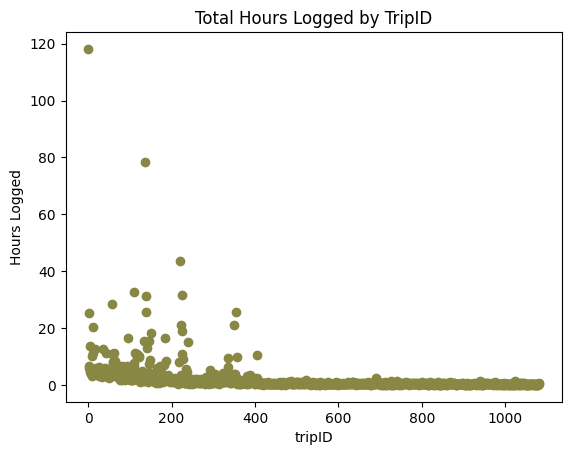

In [4]:
hours_by_trip = df['tripID'].value_counts()/(60*60)
plt.scatter(x=hours_by_trip.index, y=hours_by_trip,
           color='#888844')
plt.title('Total Hours Logged by TripID')
plt.xlabel('tripID')
plt.ylabel('Hours Logged')
plt.show()

In [5]:
hours_by_trip.sort_values(ascending=False).head(5)

0      118.153056
136     78.261111
220     43.567500
109     32.806667
224     31.734444
Name: tripID, dtype: float64

In [6]:
trips_to_exclude = set([0, 136, 220])
df = df[~df['tripID'].isin(trips_to_exclude)]

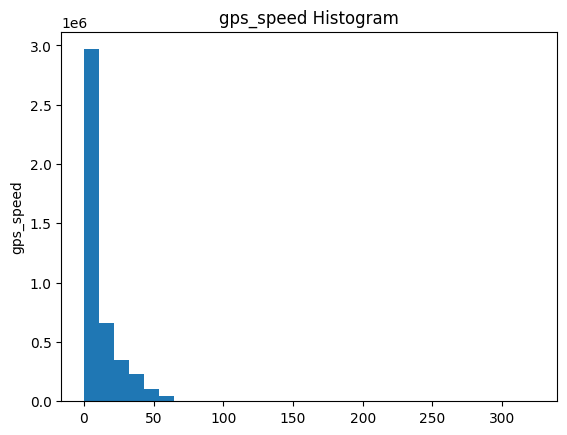

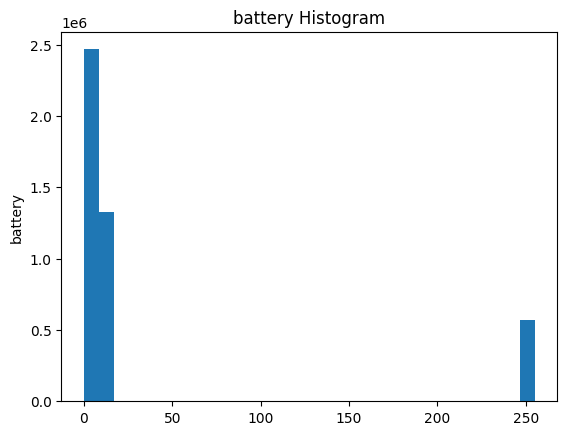

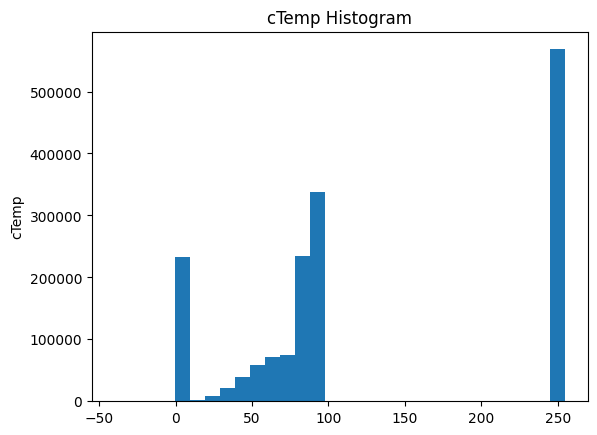

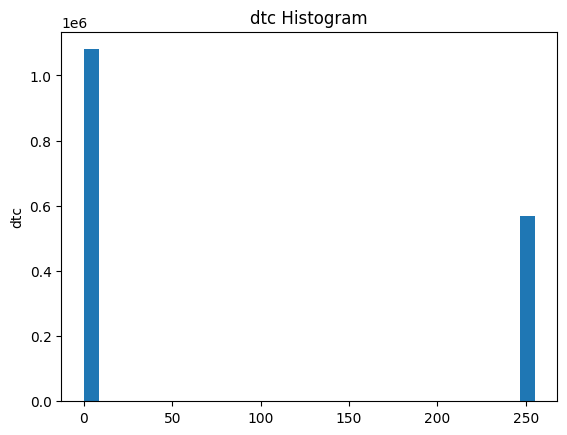

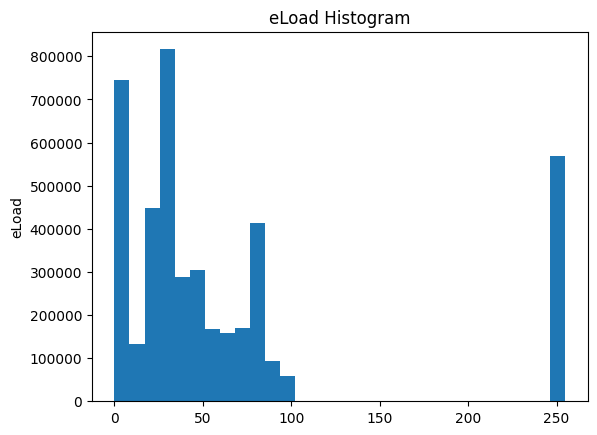

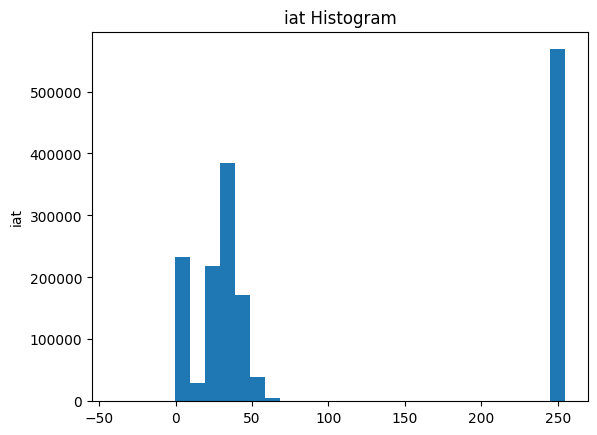

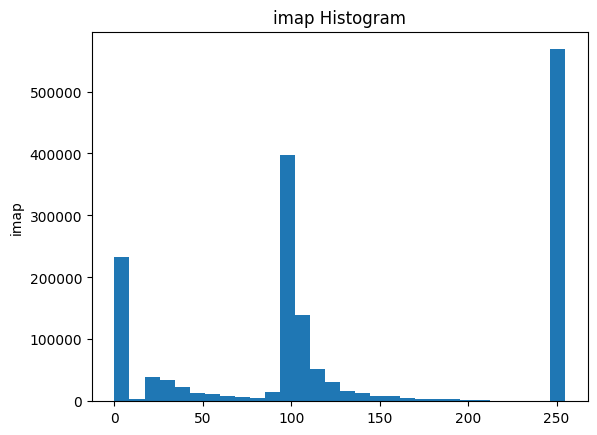

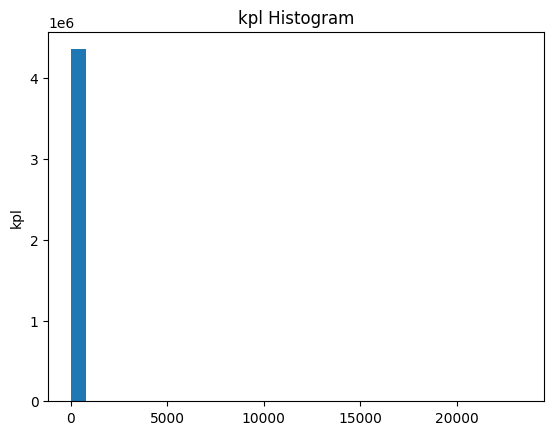

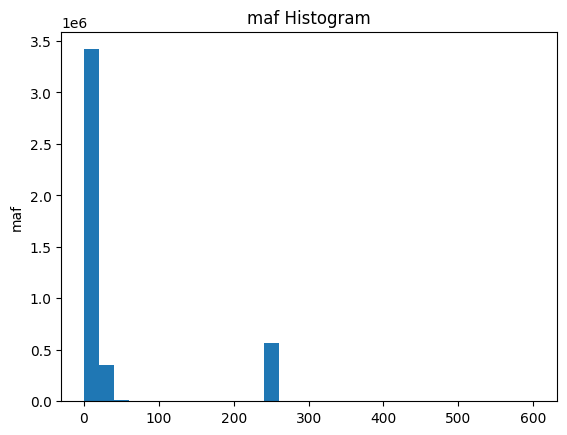

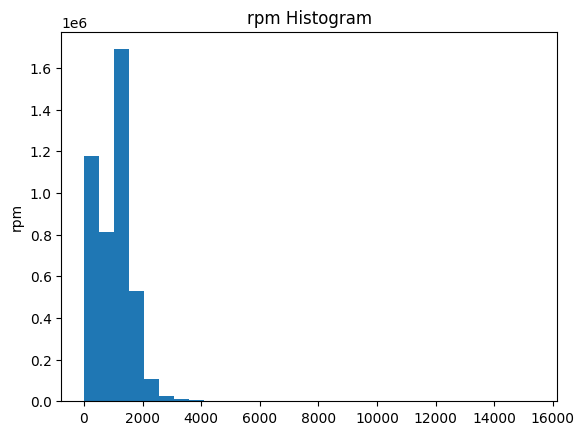

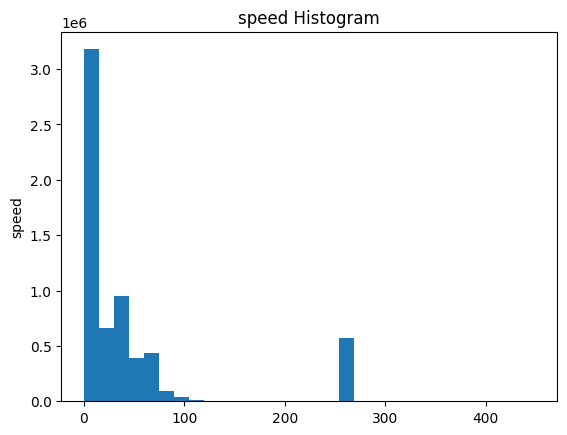

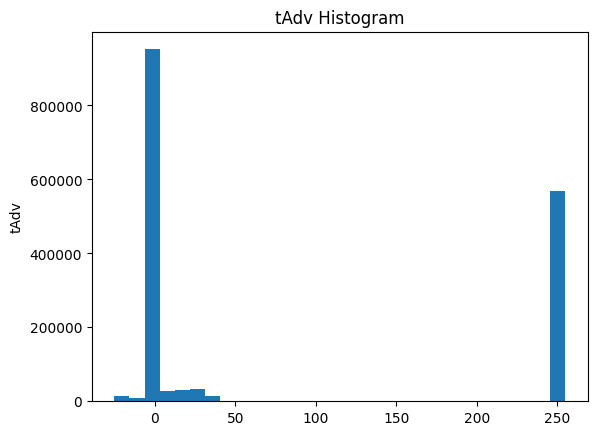

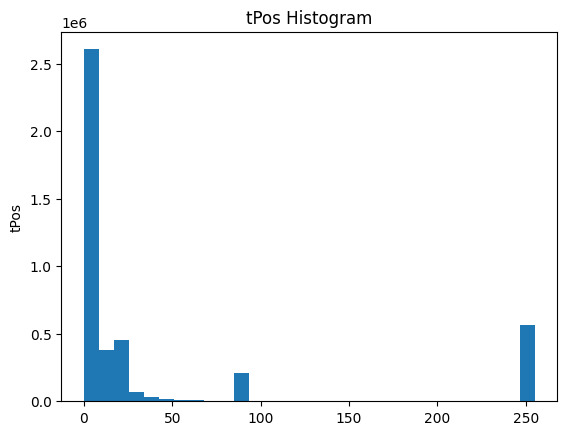

In [7]:
cols_to_not_plot = set([
    'timeStamp',
    'tripID',
    'accData',
    'deviceID'
])

for col in df.columns:
    if col not in cols_to_not_plot:
        plt.hist(df[col], bins=30)
        plt.title(f'{col} Histogram')
        plt.ylabel(col)
        plt.show()

In [8]:
# timeStamp: used to calculate first derivatives
# rpm: revolutions per minute (engine)
# tPos: position of throttle (gas pedal)
cols_to_use = [
    'timeStamp',
    'tripID',
    'rpm',
    'speed',
    'tPos'
]

df = df[cols_to_use]

In [9]:
# filtering out suspiciously high speed measurements
df = df[df['speed'] < 157]
# tPos has a very thick right tail which is extremely unlikely
df = df[df['tPos'] < 80]
df.loc[:, 'timeStamp'] = pd.to_datetime(df['timeStamp'])

In [10]:
def get_derivative(df, feature_in, feature_out) -> pd.DataFrame:
    '''Gets first derivative of inputted_feature with respect to time'''
    df_out = df.copy()
    df_out['diff'] = df_out[feature_in].diff()
    df_out[feature_out] = df_out['diff'] / df_out['timeDelta']
    df_out.drop('diff', axis=1, inplace=True)
    return df_out

def get_summary_1(df, feature_in) -> list:
    '''Gets various n-th percentile statistics for POSITIVE
    values of a given feature. Values of zero
    exluded in calculation
    '''
    res = []
    df_out = df.copy()
    df_out[feature_in + '_+ve'] = df_out[feature_in].map(lambda x : x if x > 0 else np.nan)
    
    q = [0.1*k for k in range(1, 10)] + [0.9 + 0.01*k for k in range(1, 10)]
    q.extend([0.995, 0.9975, 0.999, 0.9995, 0.99975])
    quantiles = np.nanquantile(df_out[feature_in + '_+ve'], q)
    for a, b in zip(q, quantiles):
        label = f'{feature_in}_+ve_{a:.6f}'
        res.append((label, b))
    
    std_label = f'{feature_in}_+ve_std'
    res.append((std_label, np.nanstd(df_out[feature_in + '_+ve'])))
    
    return res

def get_summary_2(df, feature_in) -> list:
    '''Gets various n-th percentile statistics for POSITIVE
    AND NEGATIVE values of a given feature. Values of zero
    exluded in calculation'''
    res = []
    df_out = df.copy()
    df_out[feature_in + '_-ve'] = df_out[feature_in].map(lambda x: x if x < 0 else np.nan)
    df_out[feature_in + '_+ve'] = df_out[feature_in].map(lambda x: x if x > 0 else np.nan)
    
    q_neg = [0.01*k for k in range(1, 10)] + [0.1*k for k in range(1, 10)]
    q_pos = [0.1*k for k in range(1, 10)] + [0.9 + 0.01*k for k in range(1, 10)]
    
    quantiles_neg = np.nanquantile(df_out[feature_in + '_-ve'], q_neg)
    quantiles_pos = np.nanquantile(df_out[feature_in + '_+ve'], q_pos)
    
    for a, b in zip(q_neg, quantiles_neg):
        label = f'{feature_in}_-ve_{a:.6f}'
        res.append((label, b))
    for a, b in zip(q_pos, quantiles_pos):
        label = f'{feature_in}_+ve_{a:.6f}'
        res.append((label, b))
    
    std_neg_label = f'{feature_in}_-ve_std'
    res.append((std_neg_label, np.nanstd(df_out[feature_in + '_-ve'])))
    
    std_pos_label = f'{feature_in}_+ve_std'
    res.append((std_pos_label, np.nanstd(df_out[feature_in + '_+ve'])))
    
    return res

def clean_trip(df, trip_id, min_datapoints=1800, verbose=False) -> pd.DataFrame:
    '''Given the original DataFrame and a trip_id, returns
    a one-line DataFrame containing a variety of relevant
    statistics pertaining to the trip_id'''
    if verbose:
        print(f'Trying Trip ID {trip_id}')
    df_trip = df.copy()
    # filter on tripID
    df_trip = df_trip[df_trip['tripID'] == trip_id]
    # confirm that data is sorted chronologically
    df_trip.sort_values(by='timeStamp', inplace=True)
    # compute time differential from previous observation
    df_trip['timeDelta'] = df_trip['timeStamp'].diff().dt.total_seconds()
    # only keep values where timeDelta is 1 second
    df_trip = df_trip[(df_trip['timeDelta'] == 1.0)]
    
    features_to_derive = [
        ('speed', 'accel'),
        ('rpm', 'rpm_d1'), #rpm and its first derivative
        ('tPos', 'tPos_d1') #throttle position and its first derivative
    ]
    
    # engineer first derivatives for our features wrt time
    for feature_in, feature_out in features_to_derive:
        df_trip = get_derivative(df_trip, feature_in, feature_out)
    
    # all the new percentile statistics that we need to calculate
    # for the given trip
    all_new_features = {}
    
    # throttle position and speed cannot be negative, so we're most
    # concerened with right-tail statistics, and we want to exclude
    # values of zero when we calculate these stats
    features_to_summarize_1 = [
        'tPos',
        'speed'
    ]
    
    # all of these can be positive and negative, and we're interested
    # in extreme values on both sides (e.g. hard braking and hard
    # acceleration) ... again we exclude values of zero since
    # they could distort our results and likely mislead us
    features_to_summarize_2 = [
        'tPos_d1',
        'accel',
        'rpm_d1'
    ]
    
    # filter out all unreasonably high acceleration values in either
    # direction... likely instrumentation error :(
    # in this case I would consult data engineers and see why we're
    # getting insanely high acceleration metrics... data integrity
    # is paramount and I'd want to clarify these results before
    # continuing any further
    #
    # random sidenote:
    # FYI, the way I actually discovered these crazy high values
    # was when I first ran this notebook WITHOUT the filter and quickly
    # went over the outputted results ... pretty awkward to put in the
    # plot here, but just want to clarify where I got these cutoffs from
    # and why I implemented them
    df_trip = df_trip[(df_trip['accel'] > -70) & (df_trip['accel'] < 50)]
    
    # exlude trips with less than 30 minutes (by default)
    # of cumulative trip time
    if len(df_trip) < min_datapoints:
        if verbose:
            print(f'Trip ID {trip_id} has insufficent (<{min_datapoints}) datapoints. n={len(df_trip)}')
        return pd.DataFrame()
    else:
        if verbose:
            print(f'Trip ID {trip_id} has sufficent datapoints. Trip summary added. n={len(df_trip)}')
    
    for feat in features_to_summarize_1:
        new_features = get_summary_1(df_trip, feat)
        for name, value in new_features:
            all_new_features[name] = [value]
    
    for feat in features_to_summarize_2:
        new_features = get_summary_2(df_trip, feat)
        for name, value in new_features:
            all_new_features[name] = [value]
    
    df_summarized = pd.DataFrame(all_new_features)
    return df_summarized

In [11]:
# build the DataFrame
df_master = None
trip_ids = set(df['tripID'].values)
for trip_id in trip_ids:
    df_new = clean_trip(df, trip_id)
    if len(df_new) == 1:
        if df_master is None:
            df_master = df_new
        else:
            df_master = pd.concat([df_master, df_new])

/home/cjporteo/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/cjporteo/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [12]:
# some final cleaning
df_master.dropna(axis=0, inplace=True)
df_master.reset_index(drop=True, inplace=True)
df_master

,tPos_+ve_0.100000,tPos_+ve_0.200000,tPos_+ve_0.300000,tPos_+ve_0.400000,tPos_+ve_0.500000,tPos_+ve_0.600000,tPos_+ve_0.700000,tPos_+ve_0.800000,tPos_+ve_0.900000,tPos_+ve_0.910000,...,rpm_d1_+ve_0.920000,rpm_d1_+ve_0.930000,rpm_d1_+ve_0.940000,rpm_d1_+ve_0.950000,rpm_d1_+ve_0.960000,rpm_d1_+ve_0.970000,rpm_d1_+ve_0.980000,rpm_d1_+ve_0.990000,rpm_d1_-ve_std,rpm_d1_+ve_std
0,12.549020,13.725490,13.725490,14.117647,14.901961,16.078431,18.039216,20.392157,25.098039,25.776471,...,1215.89,1341.335,1482.620,1619.3875,1714.49,1831.0975,1962.19,2122.5575,577.335201,604.131676
1,12.941176,13.882353,14.509804,14.509804,14.901961,15.294118,16.078431,17.254902,19.725490,20.392157,...,646.27,833.320,887.480,988.4500,1115.74,1294.2200,1428.32,1474.1500,345.724384,326.814550
2,12.941176,14.117647,14.509804,15.294118,15.686275,17.254902,19.215686,21.960784,25.882353,26.666667,...,261.09,283.115,304.585,350.2875,403.51,498.0500,784.37,945.7900,180.690215,170.659882
3,12.549020,13.333333,13.725490,14.117647,14.117647,14.509804,15.686275,18.039216,21.215686,21.568627,...,279.71,303.500,333.230,372.6000,430.55,519.2500,651.86,881.0400,179.369146,170.978184
4,13.725490,14.117647,14.509804,15.529412,16.862745,18.431373,19.607843,20.784314,23.137255,23.529412,...,198.96,218.750,242.440,266.3500,304.45,357.0250,417.35,663.3900,165.112781,136.704562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,4.117647,6.352941,11.058824,16.470588,16.862745,25.882353,31.372549,42.196078,45.098039,45.141176,...,189.88,197.760,213.160,246.6000,262.94,288.6600,339.56,403.7200,99.496426,85.719797
481,2.352941,7.058824,10.980392,14.509804,19.019608,24.313725,31.372549,39.058824,51.764706,52.996078,...,279.96,289.000,300.920,320.6250,335.32,360.2300,385.90,433.3000,148.703842,105.512974
482,1.960784,4.000000,7.450980,10.196078,13.137255,14.509804,18.823529,23.921569,30.549020,33.592157,...,160.28,171.780,187.330,203.8000,245.20,283.1400,349.32,412.0200,116.389510,90.273639
483,2.784314,6.745098,10.980392,13.725490,17.647059,21.960784,25.882353,33.647059,43.882353,45.490196,...,238.54,251.160,266.120,284.0000,323.63,352.3200,408.84,510.6600,144.560546,108.145850


In [13]:
# export for analysis :)
df_master.to_csv('./data/data_cleaned.csv', index=False)